Crack classification model

ANNOTATED DATASET PREPARATION

In [16]:
import os
import cv2

def extract_patches(annotation_folder, output_folder, image_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Output folder '{output_folder}' created.")

    for annotation_file in os.listdir(annotation_folder):
        if annotation_file.endswith('.txt'):
            # Read annotation file
            annotation_path = os.path.join(annotation_folder, annotation_file)
            with open(annotation_path, 'r') as f:
                lines = f.readlines()

            # Load corresponding image
            image_name = annotation_file.replace('.txt', '.png')  
            image_path = os.path.join(image_folder, image_name)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error: Unable to load image {image_name}")
                continue

            for i, line in enumerate(lines):
                parts = line.strip().split()
                severity, x1, y1, x2, y2 = parts[0], int(parts[1]), int(parts[2]), int(parts[3]), int(parts[4])

                # Extract patch
                patch = image[y1:y2, x1:x2]
                severity_folder = os.path.join(output_folder, severity)
                if not os.path.exists(severity_folder):
                    os.makedirs(severity_folder)

                # Save the patch
                patch_name = f"{os.path.splitext(image_name)[0]}_{i}.png"
                patch_path = os.path.join(severity_folder, patch_name)
                cv2.imwrite(patch_path, patch)
                print(f"Saved patch: {patch_path}")

# Paths
annotation_folder = r'C:\Users\aryak\OneDrive\Desktop\Crack classifier\annotated_images6'
image_folder = r'C:\Users\aryak\OneDrive\Desktop\Crack classifier\dataset\enhanced_images'
output_folder = 'pipeline_crack_patches'

#using extract patch function
extract_patches(annotation_folder, output_folder, image_folder)


Saved patch: pipeline_crack_patches\minor\pipeline_0_0.png
Saved patch: pipeline_crack_patches\minor\pipeline_0_1.png
Saved patch: pipeline_crack_patches\minor\pipeline_0_2.png
Saved patch: pipeline_crack_patches\minor\pipeline_0_3.png
Saved patch: pipeline_crack_patches\minor\pipeline_0_4.png
Saved patch: pipeline_crack_patches\minor\pipeline_0_5.png
Saved patch: pipeline_crack_patches\minor\pipeline_0_6.png
Saved patch: pipeline_crack_patches\minor\pipeline_0_7.png
Saved patch: pipeline_crack_patches\minor\pipeline_0_8.png
Saved patch: pipeline_crack_patches\minor\pipeline_0_9.png
Saved patch: pipeline_crack_patches\minor\pipeline_0_10.png
Saved patch: pipeline_crack_patches\minor\pipeline_0_11.png
Saved patch: pipeline_crack_patches\minor\pipeline_0_12.png
Saved patch: pipeline_crack_patches\minor\pipeline_0_13.png
Saved patch: pipeline_crack_patches\moderate\pipeline_0_14.png
Saved patch: pipeline_crack_patches\moderate\pipeline_0_15.png
Saved patch: pipeline_crack_patches\minor\pi

Libraries

In [4]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.optim as optim


Transformation

In [5]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


Loading dataset

In [6]:
data_dir = r'C:\Users\aryak\OneDrive\Desktop\Crack classifier\pipeline_crack_patches'
dataset = datasets.ImageFolder(data_dir, transform=transform)


Splitting into training and validation dataset

In [7]:
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


Data loaders

In [32]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True,num_workers=4)  
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False,num_workers=4) 


Loading the pre trained MobileNetV2

In [33]:
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, len(dataset.classes))
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = model.to(device)



Using device: cuda


Optimizer

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Function for trainig

In [35]:
# Import the necessary modules
from torch.cuda.amp import GradScaler, autocast

# Initialize the GradScaler
scaler = GradScaler()

# Training loop with mixed precision
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Use autocast for mixed-precision training
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            
            # Scale the loss and backpropagate
            scaler.scale(loss).backward()
            
            # Update the model
            scaler.step(optimizer)
            scaler.update()
            
            running_loss += loss.item()
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}, Val Accuracy: {correct/total:.4f}")


C:\Users\aryak\AppData\Local\Temp\ipykernel_9808\2152813013.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Training the model

In [38]:
train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)


C:\Users\aryak\AppData\Local\Temp\ipykernel_9808\2152813013.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1, Train Loss: 0.1853, Val Loss: 0.1516, Val Accuracy: 0.9356
Epoch 2, Train Loss: 0.1721, Val Loss: 0.1795, Val Accuracy: 0.9215
Epoch 3, Train Loss: 0.1678, Val Loss: 0.1574, Val Accuracy: 0.9352
Epoch 4, Train Loss: 0.1645, Val Loss: 0.1654, Val Accuracy: 0.9353
Epoch 5, Train Loss: 0.1578, Val Loss: 0.1552, Val Accuracy: 0.9347
Epoch 6, Train Loss: 0.1553, Val Loss: 0.1546, Val Accuracy: 0.9336
Epoch 7, Train Loss: 0.1497, Val Loss: 0.1873, Val Accuracy: 0.9253
Epoch 8, Train Loss: 0.1484, Val Loss: 0.1735, Val Accuracy: 0.9249
Epoch 9, Train Loss: 0.1441, Val Loss: 0.1734, Val Accuracy: 0.9260
Epoch 10, Train Loss: 0.1391, Val Loss: 0.2082, Val Accuracy: 0.9120


MODEL ACCURACY REPORT

In [39]:
import torch
from sklearn.metrics import precision_score, recall_score, f1_score

# Function to Calculate accuracy, precision, recall, and F1-score
def compute_metrics(predictions, labels):
    # Get predictions
    preds = predictions.argmax(dim=1)
    
    # Calculate accuracy
    accuracy = (preds == labels).sum().item() / labels.size(0)
    
    # Calculate precision, recall, and F1 score
    precision = precision_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=1)
    recall = recall_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=1)
    f1 = f1_score(labels.cpu(), preds.cpu(), average='weighted', zero_division=1)
    
    return accuracy, precision, recall, f1

# Function to generate accuracy report 
def generate_accuracy_report(model, train_loader, val_loader, criterion, device):
    # Initialize variables for metrics
    train_accuracy = 0.0
    train_precision = 0.0
    train_recall = 0.0
    train_f1 = 0.0
    val_accuracy = 0.0
    val_precision = 0.0
    val_recall = 0.0
    val_f1 = 0.0
    
    # Training 
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()
        
        # Calculate metrics
        accuracy, precision, recall, f1 = compute_metrics(outputs, labels)
        train_accuracy += accuracy
        train_precision += precision
        train_recall += recall
        train_f1 += f1
        
    # Validation 
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Calculate metrics
            accuracy, precision, recall, f1 = compute_metrics(outputs, labels)
            val_accuracy += accuracy
            val_precision += precision
            val_recall += recall
            val_f1 += f1
    
    # Average metrics for the entire dataset
    train_accuracy /= len(train_loader)
    train_precision /= len(train_loader)
    train_recall /= len(train_loader)
    train_f1 /= len(train_loader)
    
    val_accuracy /= len(val_loader)
    val_precision /= len(val_loader)
    val_recall /= len(val_loader)
    val_f1 /= len(val_loader)
    
    # Print the report
    print("Training Metrics:")
    print(f"Train Accuracy: {train_accuracy:.4f}, Train Precision: {train_precision:.4f}, Train Recall: {train_recall:.4f}, Train F1: {train_f1:.4f}")
    print("\nValidation Metrics:")
    print(f"Val Accuracy: {val_accuracy:.4f}, Val Precision: {val_precision:.4f}, Val Recall: {val_recall:.4f}, Val F1: {val_f1:.4f}")


generate_accuracy_report(model, train_loader, val_loader, criterion, device)


Training Metrics:
Train Accuracy: 0.9253, Train Precision: 0.9435, Train Recall: 0.9253, Train F1: 0.9207

Validation Metrics:
Val Accuracy: 0.9195, Val Precision: 0.9373, Val Recall: 0.9195, Val F1: 0.9154


VISUALISING THE RESULTS

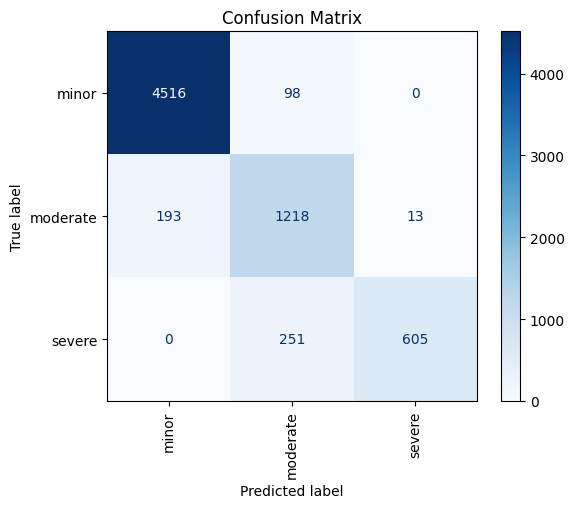

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import numpy as np
import matplotlib.pyplot as plt

# Function to plot the confusion matrix
def plot_confusion_matrix(model, dataloader, class_names, device):
    model.eval()
    all_labels = []
    all_preds = []

    # Collect true labels and predictions
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_names)))

    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

# Example 
class_names = dataset.classes
plot_confusion_matrix(model, val_loader, class_names, device)


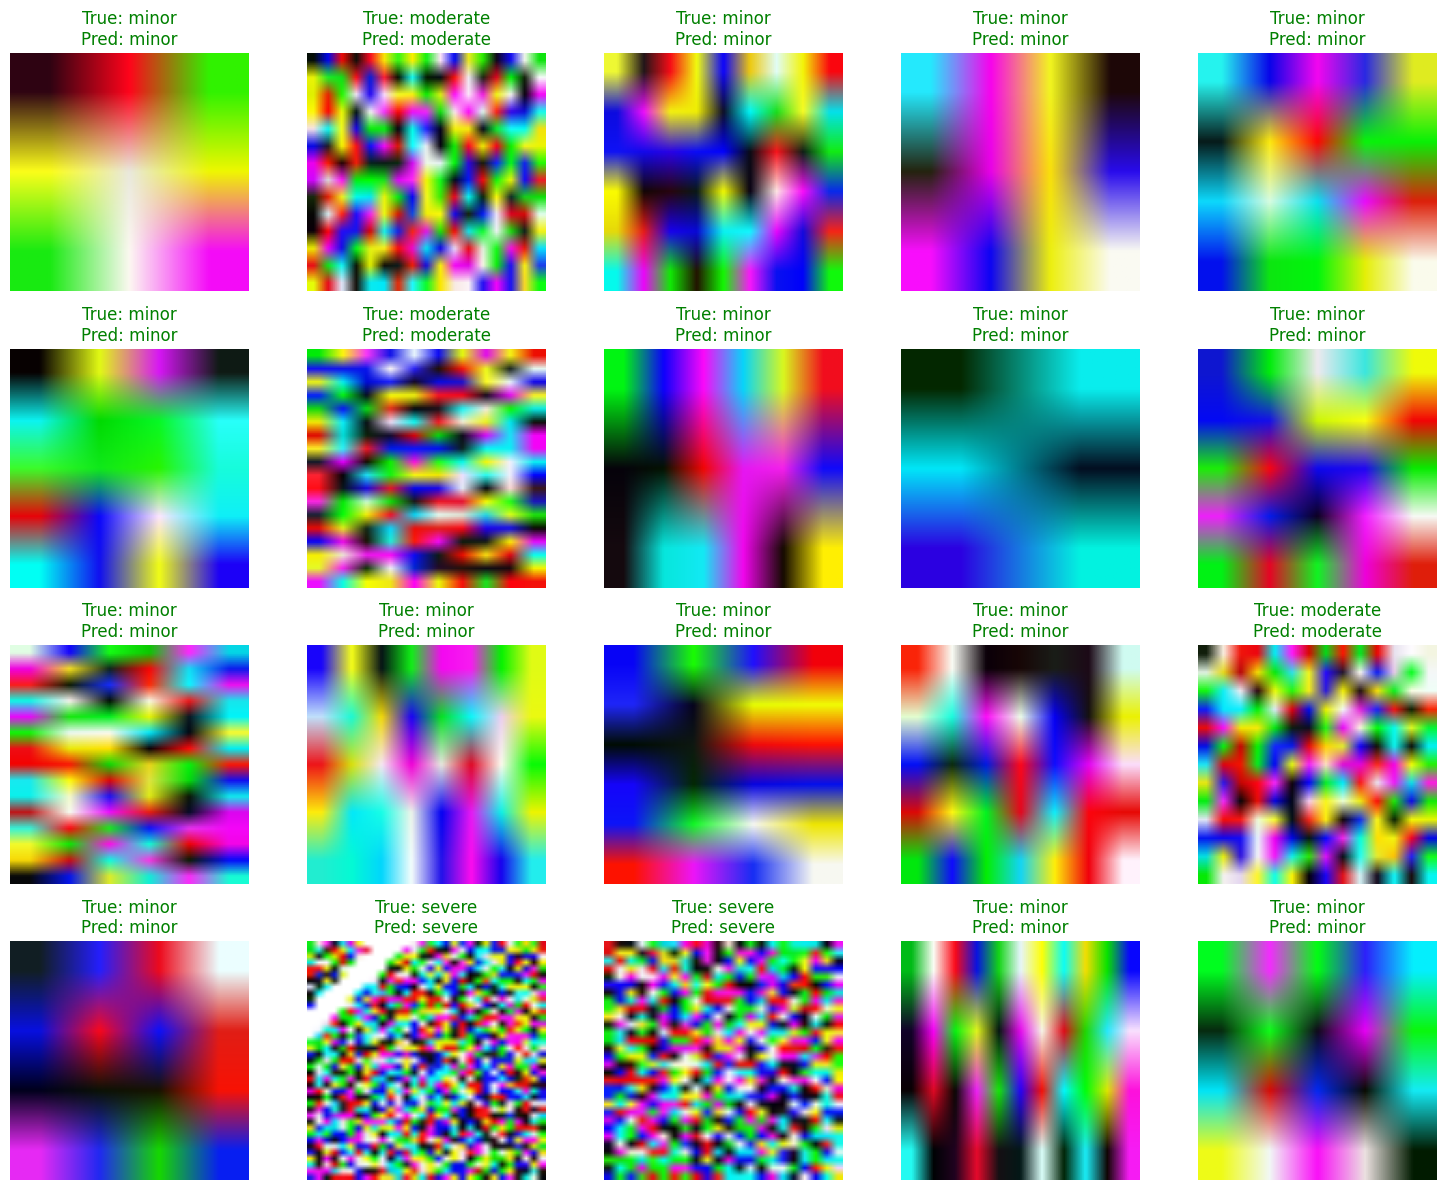

In [41]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Function to denormalize and convert tensor to numpy array 
def denormalize_and_convert(tensor):
    tensor = tensor.cpu().numpy().transpose(1, 2, 0) 
    tensor = (tensor * 0.5) + 0.5  
    tensor = np.clip(tensor, 0, 1)  
    return tensor

# Function to visualize classification results
def visualize_classification_results(model, dataloader, class_names, device):
    model.eval()
    images, labels, predictions = [], [], []

    # Collect some samples for visualization
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            preds = outputs.argmax(dim=1)

            # Collect images, true labels, and predictions
            images.extend(inputs[:5]) 
            labels.extend(targets[:5])
            predictions.extend(preds[:5])
            
            # Stop after collecting enough samples
            if len(images) >= 20:  
                break

    # Visualize the results
    fig, axes = plt.subplots(4, 5, figsize=(15, 12))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i >= len(images):  
            break
        img = denormalize_and_convert(images[i])
        true_label = class_names[labels[i].cpu().item()]
        predicted_label = class_names[predictions[i].cpu().item()]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(f"True: {true_label}\nPred: {predicted_label}", color='green' if true_label == predicted_label else 'red')
    plt.tight_layout()
    plt.show()

# Example usage
class_names = dataset.classes
visualize_classification_results(model, val_loader, class_names, device)
